In [25]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import re

%matplotlib inline

df_calendar = pd.read_csv('/Users/hmohamadi/Desktop/seattle/calendar.csv')
df_listings = pd.read_csv('/Users/hmohamadi/Desktop/seattle/listings.csv')
df_reviews = pd.read_csv('/Users/hmohamadi/Desktop/seattle/reviews.csv')

df_calendar.shape

(1393570, 4)

In [20]:
#define a new dataframe with relevant columns
df=df_listings[['id','last_scraped', 'host_name', 'host_since',
       'host_location', 'host_about','host_is_superhost','host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed','neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
       'price', 'security_deposit','cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'number_of_reviews','first_review', 'last_review',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count']]


In [21]:
#functions that will be called later

#function to convert boolean to 0-1 
def boolstr_to_floatstr(v):
    if (v==True or v=='t'):
        return '1'
    elif (v==False or v=='f'):
        return '0'
    else:
        return v
    
#function to convert currency to number   
from re import sub
from decimal import Decimal
def convert_currency_number(v):
    try:
        return (Decimal(sub(r'[^\d.]', '', v)))
    except:
        return v

#function to count number of words in a string
def number_of_words(X):return (len(X.split(',')))

#function to replace non-alphabets with underscore
def replace_non_al(x): return (re.sub(r'[^a-zA-Z0-9=]', '_',x))


In [22]:
#eliminate listings without any reviews
df2=df.drop(df[df['number_of_reviews']==0].index)
df2.shape

(3191, 41)

In [23]:
#fill null values in security deposit, cealing fee with 0, and empty for host about field, delet every remaining null value
df2.fillna(value={'security_deposit':0,'cleaning_fee':0,'host_about':''},inplace=True)
df2.dropna(axis=0,how='any',inplace=True)
df2.shape

(3140, 41)

In [26]:
#convert true/false values in below list to zero/one 
boolean_list=['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable',
              'require_guest_profile_picture','require_guest_phone_verification']
df2[boolean_list]=np.vectorize(boolstr_to_floatstr)(df2[boolean_list]).astype(float)

#convert currency values in below list to number
currency_list=['price','security_deposit','cleaning_fee','extra_people']
df2[currency_list]=np.vectorize(convert_currency_number)(df2[currency_list]).astype(float)

#replace non alphabetic characters with underscore in below list
categorical_list=['neighbourhood_group_cleansed','property_type','room_type','bed_type','cancellation_policy']
df2[categorical_list]=np.vectorize(replace_non_al)(df2[categorical_list])


In [27]:
#calculated columns
#duration a listing las been active in days
df2['listing_duration(Days)']=(pd.to_datetime(df2['last_review'])-pd.to_datetime(df2['first_review'])).astype('timedelta64[ns]').astype('timedelta64[D]')
#duration a host las been active in days
df2['hosting_duration(Days)']=(pd.to_datetime(df2['last_review'])-pd.to_datetime(df2['host_since'])).astype('timedelta64[ns]').astype('timedelta64[D]')
#number of amenities in each listing
df2['number_of_amenities']=np.vectorize(number_of_words)(df2['amenities'])
#price per person for each listing
df2['price_per_person']=df2['price']/df2['accommodates']
#is the listing among top 100 in terms of number of reviews

df2['is_top_20%'] = (df2['number_of_reviews'].rank(ascending=False)).apply(lambda x: 1 if x<=df2.shape[0]*0.2 else 0)
#df2['is_top_100'] = df2['rank'].apply(lambda x: 1 if x<=200 else 0)
#df2.loc[df2['rank']<100, 'is_top_100'] = 1


<function matplotlib.pyplot.show(*args, **kw)>

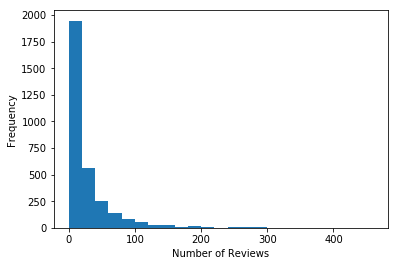

In [51]:
bin=np.arange(0,df2['number_of_reviews'].max()+1,20)
plt.hist(df2['number_of_reviews'],bins=bin)
#df2['number_of_reviews'].max()
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show


In [1044]:
#cleaned daraframe with categorical data in original form
df_origianl_clean=df2.drop(['number_of_reviews'],axis=1)

#cleaned daraframe with categorical data converted to dummies
Dummy_df=pd.get_dummies(df2[categorical_list], prefix=categorical_list, prefix_sep='_', drop_first=True)
without_dummy_df=df2.copy()
for col in categorical_list:
    without_dummy_df.drop(col, axis=1,inplace=True)
    
df_dummy_clean = pd.concat([without_dummy_df, Dummy_df], axis=1)


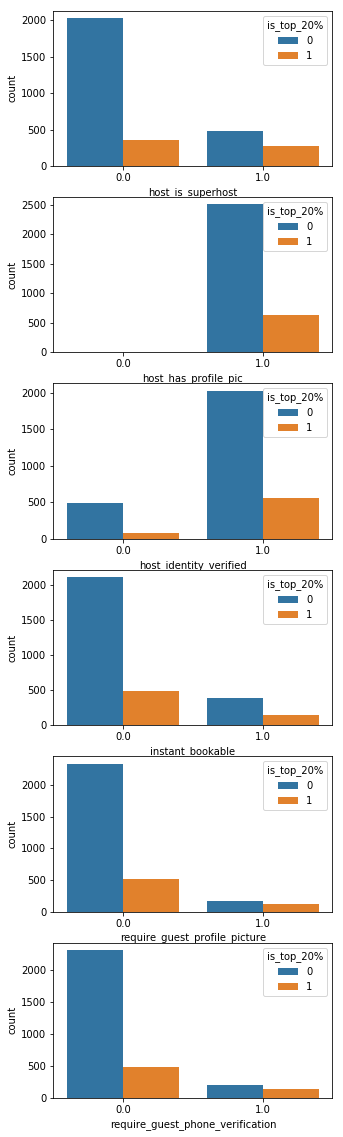

In [1008]:
plt.figure(figsize=[5,20])
i=0
for col in boolean_list:
    i+=1
    plt.subplot(len(boolean_list),1,i)
    figure=sns.countplot(x=col,hue='is_top_20%',data=df2)

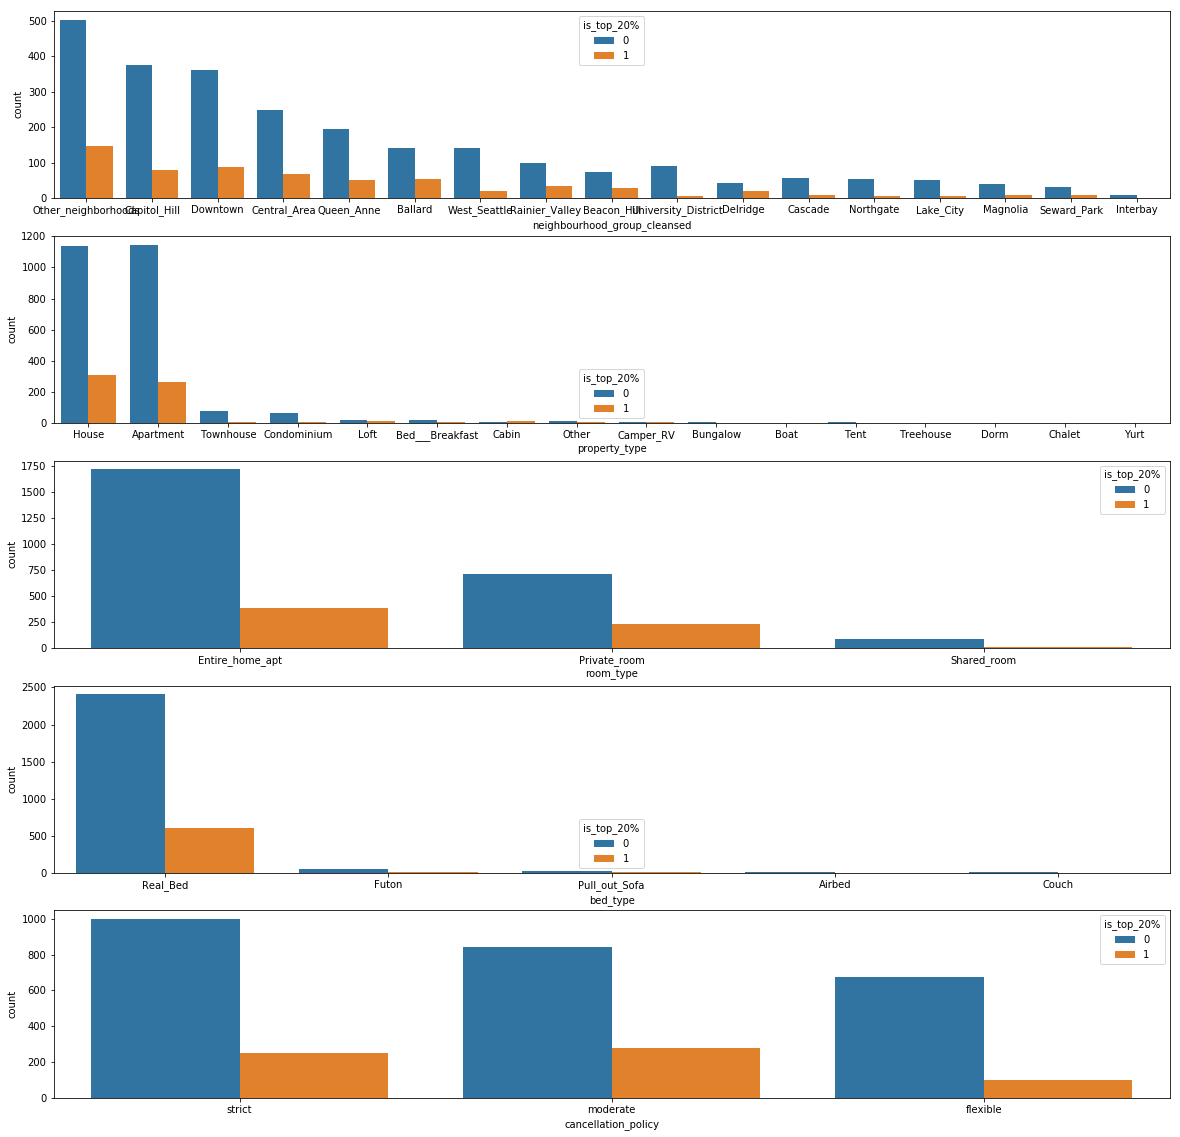

In [1009]:
plt.figure(figsize=[20,20])
i=0
for col in categorical_list:
    i+=1
    plt.subplot(len(categorical_list),1,i)
    fig=sns.countplot(x=col,hue='is_top_20%',data=df2,order=df2[col].value_counts().index)
    #fig.set_xticklabels(fig.get_xticklabels(), rotation=90)

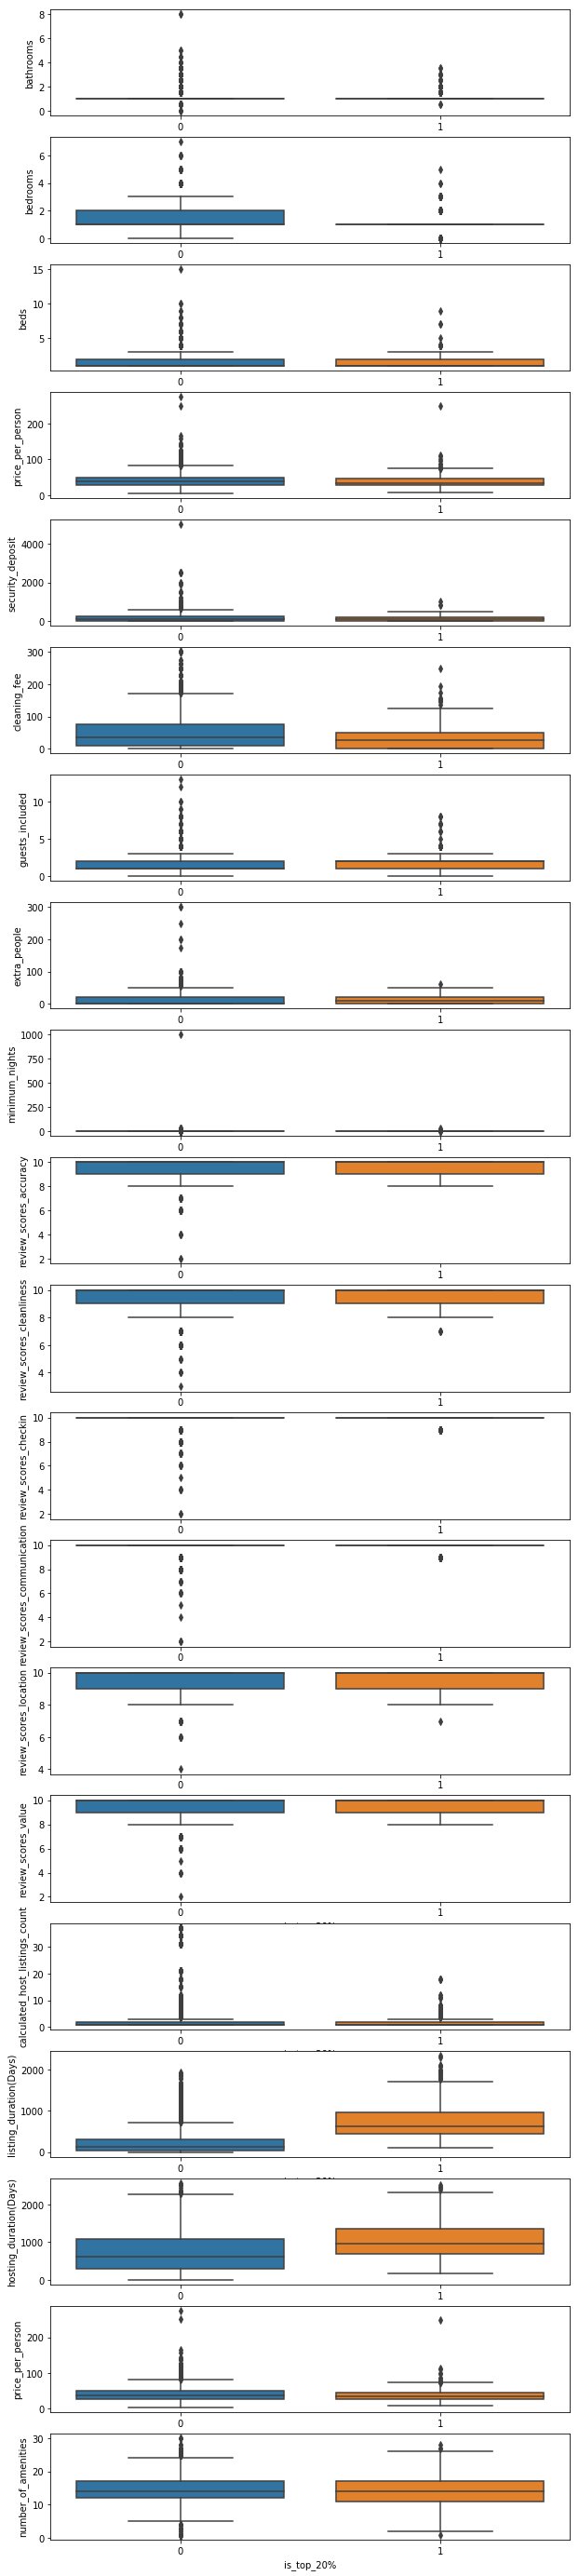

In [1010]:
continous_list=['bathrooms','bedrooms','beds','price_per_person','security_deposit','cleaning_fee','guests_included',
                'extra_people','minimum_nights','review_scores_accuracy','review_scores_cleanliness',
                'review_scores_checkin','review_scores_communication','review_scores_location',
                'review_scores_value','calculated_host_listings_count','listing_duration(Days)', 
                'hosting_duration(Days)','price_per_person','number_of_amenities']
plt.figure(figsize=[10,50])
i=0
for col in continous_list:
    i+=1
    fig=plt.subplot(len(continous_list),1,i)
    sns.boxplot(x='is_top_20%',y=col,data=df2)#,order=df2[col].value_counts().index)
    #fig.set_xticklabels(fig.get_xticklabels(), rotation=90)

Text(0,0.5,'Mean Price')

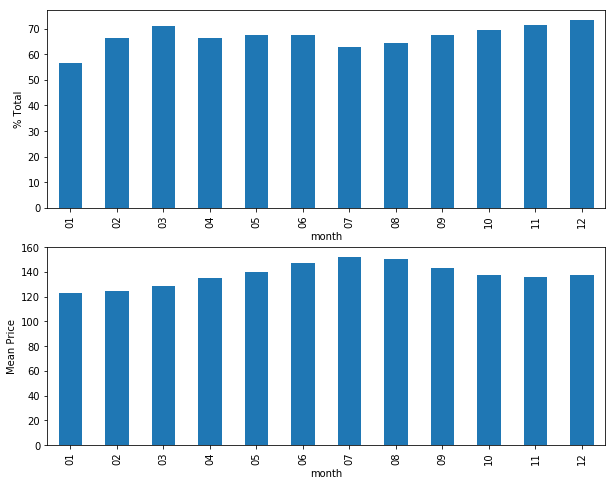

In [1011]:
df_calendar['price_num']=np.vectorize(convert_currency_number)(df_calendar['price']).astype(float)
df_calendar_available=df_calendar.copy()
df_calendar_available.dropna(subset=['price_num'],how='any',axis=0,inplace=True)
df_calendar2=pd.DataFrame()
df_calendar.loc[:,'month']=df_calendar.loc[:,'date'].str[5:7]
df_calendar2['meanPrice']=df_calendar_booked.groupby(['month']).mean()['price_num']
df_calendar2['percentageTotal']=(df_calendar_booked.groupby('month').count()['price_num'])/(df_calendar.groupby('month').count()['listing_id'])*100

plt.figure(figsize=[10,8])
base_color = sns.color_palette()[0]

plt.subplot(2,1,1)
df_calendar_percentageTotal.plot.bar(color=base_color)
plt.ylabel('% Total')
#y.label='x'
plt.subplot(2,1,2)
df_calendar_meanPrice.plot.bar(color=base_color)
plt.ylabel('Mean Price')


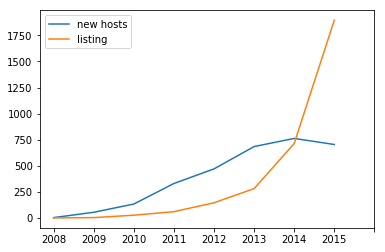

In [1012]:
df_origianl_clean.loc[:,'host_since_monthyear']=df_origianl_clean.loc[:,'host_since'].str[0:4]
df_origianl_clean.loc[:,'listing_since_monthyear']=df_origianl_clean.loc[:,'first_review'].str[0:4]
df_origianl_clean2=pd.DataFrame()
df_origianl_clean2['new hosts']=df_origianl_clean.groupby(['host_since_monthyear']).count()['id']
df_origianl_clean2['listing']=df_origianl_clean.groupby('listing_since_monthyear').count()['id']
df_origianl_clean2.fillna(0,inplace=True)
df_origianl_clean2.plot()
plt.xticks(np.arange(8), ('2008', '2009', '2010', '2011', '2012','2013','2014','2015'))
plt.xticks(np.arange(0, len(df_origianl_clean2)+1, 1.0))
plt.xlabel('')
plt.show()



In [1055]:
df_model=df_dummy_clean.drop(['id','last_scraped','host_name','host_since','host_location','host_about'
                     ,'neighbourhood_cleansed','latitude','longitude','amenities','first_review','last_review'],axis=1)#,inplace=True)
X=df_model.drop(['is_top_20%'],axis=1)
y=df_model['is_top_20%']                         
                              
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
lr_model=LogisticRegression() 
lr_model.fit(X_train,y_train)
y_test_preds = lr_model.predict(X_test)
print(r2_score(y_test, y_test_preds)) #In this case we are predicting a continuous, numeric response.  Therefore, common
print(mean_squared_error(y_test, y_test_preds)) #met

0.9540298798809267
0.0074309978768577496
